In [76]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import get_adjbox, load_dataset
from utils import inverse_minmaxscale, load_json
from visualization import get_pos_df

run_path = "my_runs/8"


ckpt_paths = [
    os.path.join(run_path, p)
    for p in os.listdir(run_path)
    if p.encode("utf-8").endswith(b".ckpt")
]

checkpoint = torch.load(ckpt_paths[0])

config = load_json(os.path.join(run_path, "config.json"))
statedict = checkpoint["state_dict"]
z_loc = statedict["z_loc"].detach().cpu().numpy()
z_scale = statedict["z_scale"].detach().cpu().numpy()
bias = statedict["bias"].detach().cpu().numpy()


events, nodes = load_dataset(config["dataset"]).values()
events.set_index("date", inplace=True)
events = events.loc[events.index[0]]
events
print(f'Loaded dataset {config["dataset"]}')

Loaded dataset highschool


In [78]:
pos_df = get_pos_df(z_loc, z_scale).set_index("node")
pos_df = pos_df.join(
    nodes.reset_index(drop=False).set_index("id").rename({"id": "node"}),
    on="node",
)

n_ticks = max(pos_df.time_index)
n_intervals = n_ticks
# Calculate degrees
pos_df.reset_index(drop=False, inplace=True)
A = get_adjbox(events, len(nodes), n_intervals)
out_degs = A.sum(axis=1)
in_degs = A.sum(axis=0)
total_degs = out_degs + in_degs
# For each node and interval, we store the number of
# interactions for that node in that interval
pos_df.loc[:, "deg"] = total_degs[
    pos_df.node.values,
    np.clip(pos_df.time_index.values, 0, n_intervals - 1),
]
# Set a size of 0 for nodes with no interactions
pos_df.loc[pos_df.deg == 0, "size"] = 0.0

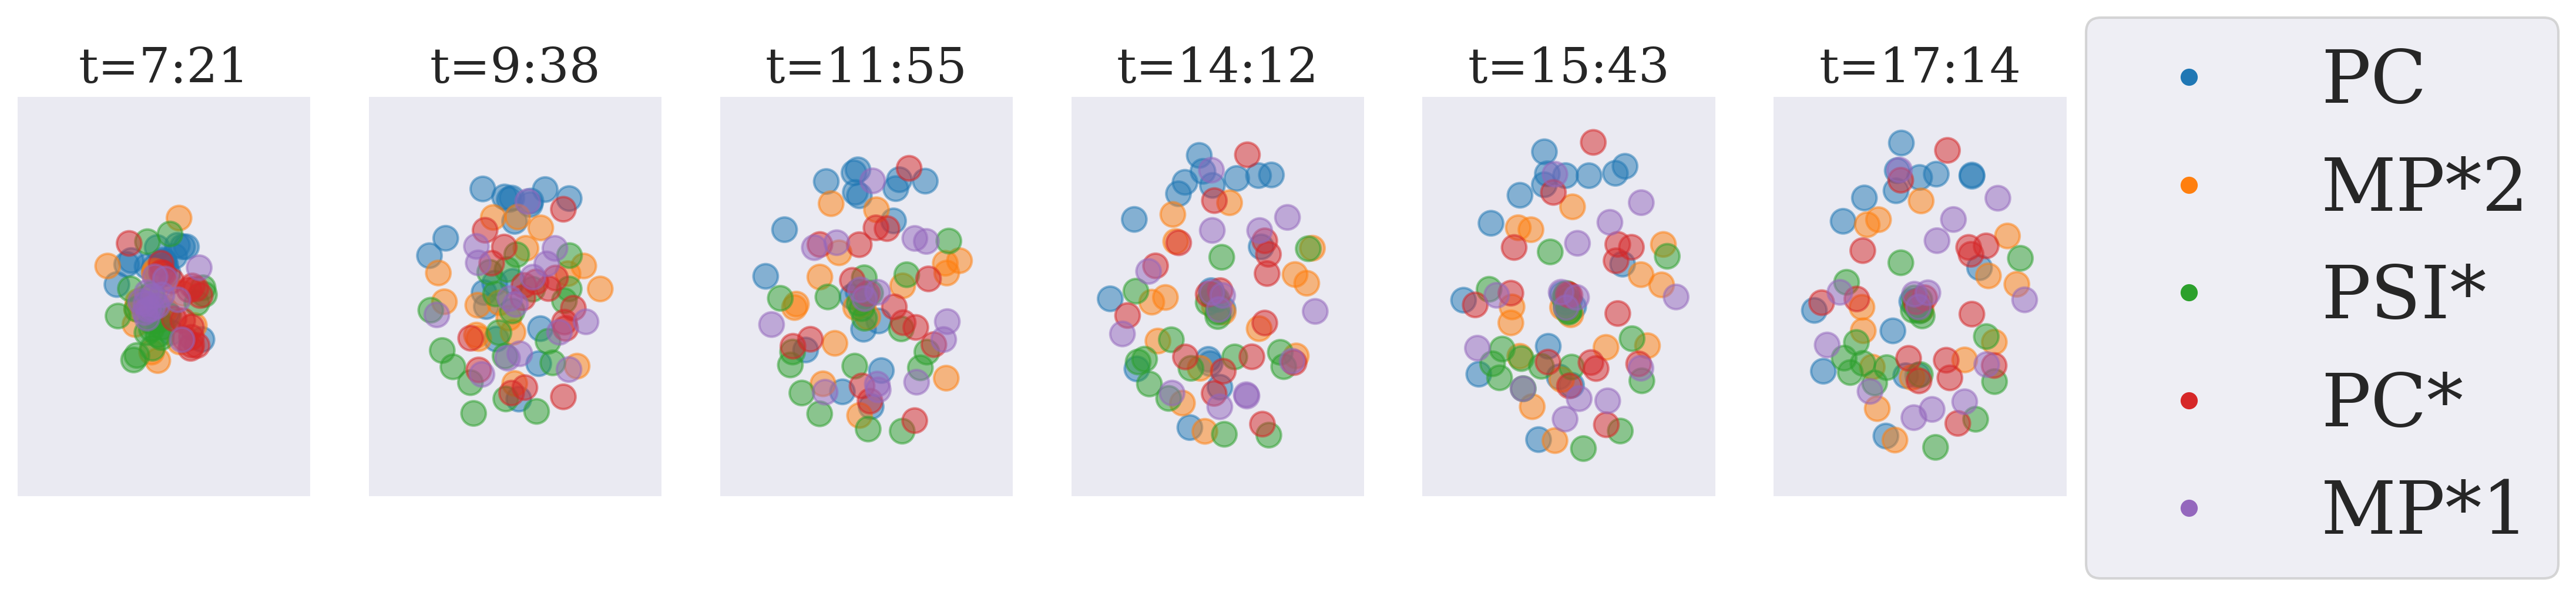

In [80]:
# sns.set_context("paper", font_scale=1.5)
from visualization import set_theme

set_theme()

class_column = "class"
size_column = "size"
n_ticks = max(pos_df.time_index)
pos_df = pos_df.reset_index(drop=True).set_index("time_index", drop=False)

cats = pos_df[class_column].unique()
n_frames = 5
frames = [i * (n_ticks // n_frames) for i in range(n_frames)]
frames = [1, 4, 7, 10, 12, 14]
class_colors = sns.color_palette("tab10", n_colors=len(cats))
class_colors = {cat: color for cat, color in zip(cats, class_colors)}
is_legend = False


fig, axs = plt.subplots(1, len(frames), figsize=(15, 3))
markers = {0: "x"}

xlim = (min(pos_df["value_x"]) - 1, max(pos_df["value_x"]) + 1)
ylim = (min(pos_df["value_y"]) - 1, max(pos_df["value_y"]) + 1)
for i, frame in enumerate(frames):
    pos_frame = pos_df.loc[frame].set_index(class_column, drop=False)
    for class_ in cats:
        pos_class = pos_frame.loc[class_]
        axs[i].scatter(
            pos_class["value_x"],
            pos_class["value_y"],
            s=pos_class[size_column],
            color=class_colors[class_],
            marker=markers.get(class_, "o"),
            alpha=0.5,
            label=class_,
            sizes=(0, 100),
        )

    # axs[i].grid(True)
    # if res is not None and not is_legend:
    #     handles, labels = res
    #     # handles.append(handles[0], "k=50, $\sigma$=1")
    #     fig.legend(handles, labels, loc="right", prop={"size": 10})
    #     is_legend = True

    real_timestamp = inverse_minmaxscale(
        frame / n_ticks,
        events["timestamp"].min(),
        events["timestamp"].max(),
    )
    real_timestamp = datetime.datetime.fromtimestamp(real_timestamp)
    hours_minutes = f"{real_timestamp.hour}:{real_timestamp.minute:02d}"
    axs[i].set_title(f"t={real_timestamp.hour}:{real_timestamp.minute:02d}")
    axs[i].set_ylim(ylim)
    axs[i].set_xlim(xlim)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
handles = [
    plt.Line2D([0], [0], color=c, marker="o", linestyle="", label=l)
    for l, c in class_colors.items()
]
labels = class_colors.keys()
fig.legend(
    handles=handles,
    labels=labels,
    loc="right",
    bbox_to_anchor=(1.1, 0.5),
)
# plt.suptitle(title, y=1.2)